# GPU Check

In [ ]:
import tensorflow as tf
import time

# Check if a GPU is available
print("Available device:", tf.config.list_physical_devices('GPU'))

# Perform an intensive operation
start = time.time()
a = tf.random.normal([10000, 10000])
b = tf.matmul(a, a)
print("GPU computation time:", time.time() - start)

Dispositivo disponibile: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tempo GPU: 0.8667232990264893


#Import Libraries

In [ ]:
# Install the mediapipe package from Python Package Index (PyPI)
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 14.0 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import to_categorical

In [ ]:
# Import the device_lib module from TensorFlow to check available hardware devices
from tensorflow.python.client import device_lib
# List and print all available devices (CPU, GPU, etc.) on the system
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1800127904332837831
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16499321067137831288
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


#Set the Directory

In [ ]:
# Import the drive module from Google Colab to access Google Drive
from google.colab import drive
# Mount Google Drive to the specified directory in Colab
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys  # Import the sys module to access system-specific parameters and functions
# Add a specific directory to the system path
sys.path.append('/content/drive/Shareddrives/AI Project 2024_2025/AI Project 2024_2025/OUR HANDS/full data tracking')

In [ ]:
# Define the path to the new directory
new_directory = '/content/drive/Shareddrives/AI Project 2024_2025/AI Project 2024_2025/OUR HANDS/full data tracking'
# Check if the specified directory exists
if os.path.exists(new_directory):
    os.chdir(new_directory)  # If the directory exists, change the current working directory to the new directory
    print("current dir:", os.getcwd())   # Print the current working directory to confirm the change
else:
    print("This directory does not exist:", new_directory)  # If the directory does not exist, print a message

Nuova directory di lavoro corrente: /content/drive/Shareddrives/AI - Project/OUR HANDS/full data tracking


In [ ]:
# Define the path to the training dataset directory
train_dir = '/content/drive/Shareddrives/AI - Project/OUR HANDS/full data tracking/asl_alphabet_train'
# Define the path to the test dataset directory
test_dir = '/content/drive/Shareddrives/AI - Project/OUR HANDS/full data tracking/asl_alphabet_test'

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Setup MediaPipe for hand tracking
mp_hands = mp.solutions.hands  # Import the hand tracking module from MediaPipe
hands = mp_hands.Hands()  # Initialize the hand tracking solution

# Function to get hand tracking data from a directory of images
def get_hand_tracking_data(data_dir):
    landmarks_list = []  # List to store the flattened hand landmarks data
    labels = []  # List to store the corresponding class labels

    # Ensure consistent order of class directories in the dataset
    dir_list = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    print(f"Found classes: {dir_list}")  # Debugging: Print all detected class directories

    # Loop through each class folder
    for label_idx, class_name in enumerate(dir_list):  # Iterate over each class folder
        print(f"Processing class '{class_name}' (Label: {label_idx})...")  # Debugging: Indicate current class
        sub_dir = os.path.join(data_dir, class_name)  # Full path to the current class folder

        if os.path.isdir(sub_dir):  # Ensure the current directory is a valid folder
            for image_name in os.listdir(sub_dir):  # Loop through each image in the subdirectory
                img_path = os.path.join(sub_dir, image_name)  # Get the full path of the image
                img = cv2.imread(img_path)  # Read the image using OpenCV

                if img is not None:  # Proceed if image is read correctly
                    img = cv2.resize(img, (480, 864))  # Resize image to match the size required for MediaPipe processing

                    # Convert the image from BGR (OpenCV format) to RGB (required by MediaPipe)
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    results = hands.process(img_rgb)  # Process the image to detect hand landmarks

                    if results.multi_hand_landmarks:  # Only proceed if hand landmarks are detected
                        for landmarks in results.multi_hand_landmarks:  # Handle multiple detected hands (if any)
                            # Flatten the landmarks (21 landmarks, each with 3 coordinates: x, y, z)
                            landmarks_flat = []
                            for landmark in landmarks.landmark:
                                landmarks_flat.append(landmark.x)
                                landmarks_flat.append(landmark.y)
                                landmarks_flat.append(landmark.z)

                            landmarks_list.append(landmarks_flat)  # Append flattened landmarks to the list
                            labels.append(label_idx)  # Append the class label for the corresponding landmarks

    # If no landmarks are detected, raise an error
    if len(landmarks_list) == 0:
        raise ValueError("No landmarks detected. Check your dataset and ensure MediaPipe is configured correctly.")

    # Return the landmarks data and labels as numpy arrays
    return np.array(landmarks_list), np.array(labels)

# Load training data by calling the function above
X, y = get_hand_tracking_data(train_dir)  # Assuming 'train_dir' is the directory with your training data

print(f"Loaded {len(X)} samples with {len(set(y))} unique classes.")  # Debugging: Print dataset info

# Check for class distribution (for debugging)
unique, counts = np.unique(y, return_counts=True)  # Get the unique class labels and their counts
print("Class distribution:")
for u, c in zip(unique, counts):  # Print the distribution of each class
    print(f"Class {u}: {c} samples")

# Determine the number of unique classes
num_classes = len(set(y))  # Automatically determine the number of classes
print(f"Detected {num_classes} classes.")  # Print number of classes

# Normalize the landmark data (convert to float32 for neural network compatibility)
X = X.astype('float32')

# One-hot encode the labels (convert label integers into one-hot encoded format)
y = to_categorical(y, num_classes=num_classes)

# Split the data into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Print shapes of training and testing data for verification
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

Found classes: ['A', 'B', 'C', 'D', 'Del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'Space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Processing class 'A' (Label: 0)...
Processing class 'B' (Label: 1)...
Processing class 'C' (Label: 2)...
Processing class 'D' (Label: 3)...
Processing class 'Del' (Label: 4)...
Processing class 'E' (Label: 5)...
Processing class 'F' (Label: 6)...
Processing class 'G' (Label: 7)...
Processing class 'H' (Label: 8)...
Processing class 'I' (Label: 9)...
Processing class 'J' (Label: 10)...
Processing class 'K' (Label: 11)...
Processing class 'L' (Label: 12)...
Processing class 'M' (Label: 13)...
Processing class 'N' (Label: 14)...
Processing class 'O' (Label: 15)...
Processing class 'P' (Label: 16)...
Processing class 'Q' (Label: 17)...
Processing class 'R' (Label: 18)...
Processing class 'S' (Label: 19)...
Processing class 'Space' (Label: 20)...
Processing class 'T' (Label: 21)...
Processing class 'U' (Label: 22)...
Processing cla

In [ ]:
# These files will store the features (x_train, x_test) and labels (y_train, y_test) in numpy array format
# Save the training features (coordinates of the hand landmarks) to a file
np.save('x_train_coordinates.npy', x_train)  # Saves the training set features (landmark coordinates) to a file
# Save the training labels (one-hot encoded) to a file
np.save('y_train_coordinates.npy', y_train)  # Saves the training set labels (class labels) to a file
# Save the test features (coordinates of the hand landmarks) to a file
np.save('x_test_coordinates.npy', x_test)  # Saves the test set features (landmark coordinates) to a file
# Save the test labels (one-hot encoded) to a file
np.save('y_test_coordinates.npy', y_test)  # Saves the test set labels (class labels) to a file

In [ ]:
# Load the saved data for further use
# Using np.load() to load the previously saved .npy files containing the training and testing data
x_train = np.load('x_train_coordinates.npy')  # Load the training features (hand landmark coordinates)
y_train = np.load('y_train_coordinates.npy')  # Load the training labels (one-hot encoded)
x_test = np.load('x_test_coordinates.npy')    # Load the test features (hand landmark coordinates)
y_test = np.load('y_test_coordinates.npy')    # Load the test labels (one-hot encoded)

# Print the shape of the data to verify its dimensions and check that everything is loaded correctly
print(f"x_train shape: {x_train.shape}")  # Display the shape of the training data (features)
print(f"y_train shape: {y_train.shape}")  # Display the shape of the training labels (one-hot encoded)
print(f"x_test shape: {x_test.shape}")    # Display the shape of the test data (features)
print(f"y_test shape: {y_test.shape}")    # Display the shape of the test labels (one-hot encoded)

# Print the pixel range to check if the values are within the expected range (e.g., [0, 1] for normalized data)
print(f"Pixel range: Min {x_test.min()}, Max {x_test.max()}")  # Check the minimum and maximum values of the test set

x_train shape: (19549, 63)
y_train shape: (19549, 28)
x_test shape: (4888, 63)
y_test shape: (4888, 28)
Pixel range: Min -1.0409889221191406, Max 1.1041605472564697


In [ ]:
# Import necessary libraries for building and training the model
from tensorflow.keras.models import Sequential  # Sequential model for stacking layers
from tensorflow.keras.layers import Dense, Dropout  # Dense layers for fully connected layers and Dropout for regularization
from tensorflow.keras.optimizers import Adam  # Adam optimizer for training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Callbacks to monitor training

# Model configuration parameters
classes = 28  # Total number of classes (signs), based on the dataset
batch_size = 128  # The number of samples per batch during training
epochs = 100  # The number of epochs (iterations over the entire dataset) to train the model
learning_rate = 0.00001  # Learning rate for the Adam optimizer (a very small value for fine-tuning)

# Initialize the Adam optimizer with the specified learning rate
adam = Adam(learning_rate)

# Define the model architecture using the Sequential API (linear stack of layers)
model = Sequential()

# Input layer: Accepts 63 input features (21 landmarks, each with 3 coordinates - x, y, z)
# The first Dense layer is fully connected with 512 neurons and ReLU activation function.
model.add(Dense(512, input_dim=63, activation='relu'))
model.add(Dropout(0.3))  # Dropout regularization (30%) to prevent overfitting

# Hidden layer 1: 512 neurons with ReLU activation
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))  # Dropout regularization again

# Hidden layer 2: 256 neurons with ReLU activation
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))  # Dropout regularization again

# Output layer: This layer has 'classes' neurons (one for each class/sign) with softmax activation
# The softmax activation ensures the output values sum to 1, representing the probability distribution over classes
model.add(Dense(classes, activation='softmax'))

# Compile the model: The optimizer is Adam, and the loss function is categorical crossentropy (for multi-class classification)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback: Stop training if the validation loss doesn't improve after 5 epochs and restore the best weights
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Reduce learning rate callback: Reduce the learning rate by half if the validation loss doesn't improve for 5 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

#Model Training

In [ ]:
# Train the model on the training data (x_train, y_train)
# Use validation data (x_test, y_test) for monitoring during training
# Train for the specified number of epochs and with the given batch size
# Callbacks include early stopping (to stop training if validation loss stops improving)
# and learning rate reduction (to decrease the learning rate if validation loss stagnates)
history = model.fit(
    x_train,  # Training features (hand landmarks)
    y_train,  # Training labels (corresponding classes)
    validation_data=(x_test, y_test),  # Validation data to evaluate the model after each epoch
    epochs=epochs,  # Number of epochs (iterations over the entire dataset)
    batch_size=batch_size,  # Number of samples per batch
    callbacks=[early_stop, reduce_lr]  # Early stopping and learning rate reduction callbacks
)

Epoch 1/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.0401 - loss: 3.3384 - val_accuracy: 0.0544 - val_loss: 3.2984 - learning_rate: 1.0000e-05
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0626 - loss: 3.3042 - val_accuracy: 0.1189 - val_loss: 3.2530 - learning_rate: 1.0000e-05
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0851 - loss: 3.2687 - val_accuracy: 0.1817 - val_loss: 3.1964 - learning_rate: 1.0000e-05
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1134 - loss: 3.2224 - val_accuracy: 0.2203 - val_loss: 3.1271 - learning_rate: 1.0000e-05
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1433 - loss: 3.1631 - val_accuracy: 0.2782 - val_loss: 3.0326 - learning_rate: 1.0000e-05
Epoch 6/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1831 - loss: 3.0834 - val_accuracy: 0.3470 - val_loss: 2.9115 - learning_rate: 1.0000e-05
Epoch 7/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - ac

#Model Evaluation

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9732 - loss: 0.1339
Test Accuracy: 0.9765
Test Loss: 0.1249


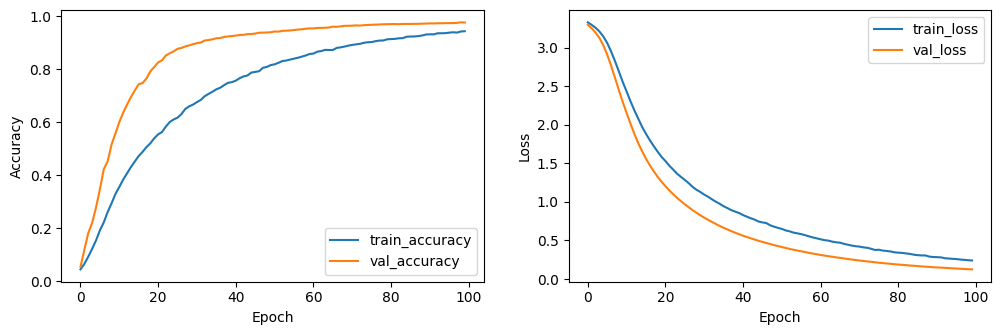

In [ ]:
# Evaluate the model on the test set using the model's evaluation method
# This computes the loss and accuracy on the test data (x_test, y_test)
test_loss, test_acc = model.evaluate(x_test, y_test)

# Print the evaluation results: test accuracy and test loss
print(f'Test Accuracy: {test_acc:.4f}')  # Print the accuracy on the test set
print(f'Test Loss: {test_loss:.4f}')  # Print the loss on the test set

# Function to plot the training and validation results (accuracy and loss over epochs)
def plot_results():
    plt.figure(figsize=(12, 12))  # Set up the figure for subplots

    # Plot training and validation accuracy over epochs
    plt.subplot(3, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')  # Plot training accuracy
    plt.plot(history.history['val_accuracy'], label='val_accuracy')  # Plot validation accuracy
    plt.xlabel('Epoch')  # Label for the x-axis
    plt.ylabel('Accuracy')  # Label for the y-axis
    plt.legend()  # Show the legend for both lines

    # Plot training and validation loss over epochs
    plt.subplot(3, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')  # Plot training loss
    plt.plot(history.history['val_loss'], label='val_loss')  # Plot validation loss
    plt.xlabel('Epoch')  # Label for the x-axis
    plt.ylabel('Loss')  # Label for the y-axis
    plt.legend()  # Show the legend for both lines

    plt.show()  # Display the plot

# Call the function to plot the results of the training
plot_results()

# Save the trained model to a file with the specified name for future use
model.save('asl_model_with_landmarks.keras')

--------------------------------------------------------------

In [ ]:
# Print the shape of y_test (test labels)
print(y_test.shape)

# Print the shape of x_test (test data/features)
print("x_test shape:", x_test.shape)

# Print the input shape of the model (the expected shape for the input data)
print("Model input shape:", model.input_shape)

(784, 5)
x_test shape: (784, 128, 128, 3)
Model input shape: (None, 128, 128, 3)


#Load the Model

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('asl_model_with_landmarks.keras')

In [ ]:
# Import necessary libraries for processing and visualization
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from tensorflow.keras.models import load_model

# Initialize MediaPipe Hands module for detecting hand landmarks
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands()

# Load the trained model
model = load_model('asl_model_with_landmarks.keras')

# Get the class labels (sorted list of directory names in the training data directory)
class_labels = sorted(os.listdir(train_dir))  # Assuming train_dir has labeled folders

# Function to visualize hand tracking data and make predictions
def visualize_hand_tracking(data_dir, model, class_labels, num_samples=28):
    # Create a subplot grid (7 rows x 4 columns) for displaying images
    fig, axes = plt.subplots(7, 4, figsize=(14, 24))  # 7x4 grid
    axes = axes.flatten()  # Flatten the 2D array to 1D for easier indexing

    sample_count = 0  # Initialize counter for the displayed samples

    # Loop through the class labels to visualize each class
    for label_idx, class_name in enumerate(class_labels):
        # Construct the path to the current class directory
        class_dir = os.path.join(data_dir, class_name)
        image_files = os.listdir(class_dir)  # List all image files in the class folder

        # Skip if no images are found in the class
        if len(image_files) == 0:
            continue

        # Load the first image for this class
        img_path = os.path.join(class_dir, image_files[0])
        img = cv2.imread(img_path)

        # Skip if the image is invalid (None)
        if img is None:
            continue

        # Convert the image to RGB (required by MediaPipe)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Process the image to detect hand landmarks using MediaPipe
        results = hands.process(img_rgb)

        # Draw hand landmarks on the image if detected
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(img_rgb, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        # Prepare landmark data for prediction
        landmark_features = []
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Collect the x, y, z coordinates of the 21 hand landmarks
                for lm in hand_landmarks.landmark:
                    landmark_features.append(lm.x)
                    landmark_features.append(lm.y)
                    landmark_features.append(lm.z)

            # Ensure there are exactly 63 features (21 landmarks with 3 coordinates each)
            if len(landmark_features) == 63:
                # Use the model to predict the class based on the landmarks
                prediction = model.predict(np.array([landmark_features]))
                predicted_label = class_labels[np.argmax(prediction)]  # Get predicted class
            else:
                predicted_label = "No Hand Detected"
        else:
            predicted_label = "No Hand Detected"  # If no hand landmarks detected

        # Display the image with hand landmarks and predictions
        axes[sample_count].imshow(img_rgb)  # Show the image
        axes[sample_count].set_title(f"True: {class_name}\nPred: {predicted_label}")  # Title with true and predicted labels
        axes[sample_count].axis("off")  # Hide axes

        sample_count += 1  # Increment sample counter
        if sample_count >= num_samples:  # Stop if the maximum number of samples is reached
            break

    # Adjust layout and display the images in the grid
    plt.tight_layout()
    plt.show()

# Call the function to visualize hand tracking on the training data
visualize_hand_tracking(train_dir, model, class_labels)

# Function to plot training accuracy and loss for the model
def plot_results(history):
    # Create a figure with 2 subplots for accuracy and loss
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy Plot
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')  # Training accuracy
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')  # Validation accuracy
    axes[0].set_xlabel('Epochs')  # X-axis label (epochs)
    axes[0].set_ylabel('Accuracy')  # Y-axis label (accuracy)
    axes[0].set_title('Model Accuracy')  # Title for accuracy plot
    axes[0].legend()  # Show legend

    # Loss Plot
    axes[1].plot(history.history['loss'], label='Train Loss')  # Training loss
    axes[1].plot(history.history['val_loss'], label='Validation Loss')  # Validation loss
    axes[1].set_xlabel('Epochs')  # X-axis label (epochs)
    axes[1].set_ylabel('Loss')  # Y-axis label (loss)
    axes[1].set_title('Model Loss')  # Title for loss plot
    axes[1].legend()  # Show legend

    # Display the plots
    plt.show()

# Call the function to plot the training performance
plot_results(history)

Output hidden; open in https://colab.research.google.com to view.

No furhter analysis were performed since the model had a limited predictive power when dragged in the interface. We moved to "Only x and Y" file, where we tested with simpler tracking and resulted in better performance.